# JAX demo: Can we clone a PHOENIX stellar model spectrum?

Let's demo using JAX for blasé.

In [1]:
from gollum.phoenix import PHOENIXSpectrum
%matplotlib inline
%config InlineBackend.figure_format='retina'

`blasé` is much faster if you happen to have an NVIDIA® GPU.  Most consumer laptops don't have this hardware, but `cpu` codes will still work (just slower)!

### Set the wavelength limits

We will target a relatively narrow chunk of spectrum: $11000 - 11180$ Å.  We use a $60$ Å buffer to deal with edge effects.

In [2]:
wl_lo = 11_000-60
wl_hi = 11_180+60

## Read in a precomputed synthetic stellar spectrum

The [gollum](http://gollum-astro.readthedocs.io) precomputed synthetic spectral model interface makes this step pretty straightforward.  You don't even need to have the file locally-- gollum can fetch it for you.

In [3]:
stellar_spectrum = PHOENIXSpectrum(teff=4700, logg=4.5, 
                                   wl_lo=wl_lo, wl_hi=wl_hi, download=True)

The pristine PHOENIX spectrum needs to be flattened to facilitate line finding:  We first divide out the black body and then divide by a $5^{th}$ order polynomial.

In [4]:
stellar_spectrum = stellar_spectrum.divide_by_blackbody()
stellar_spectrum = stellar_spectrum.normalize()

Bummer, gollum is broken for some reason!!

In [5]:
#stellar_spectrum.fit_continuum()

Just do it manually...

In [6]:
from specutils.fitting import fit_generic_continuum
cont_norm_spec = stellar_spectrum / fit_generic_continuum(stellar_spectrum)(stellar_spectrum.spectral_axis) 

In [7]:
stellar_spectrum = cont_norm_spec.normalize(percentile=99)

(0.0, 1.1)

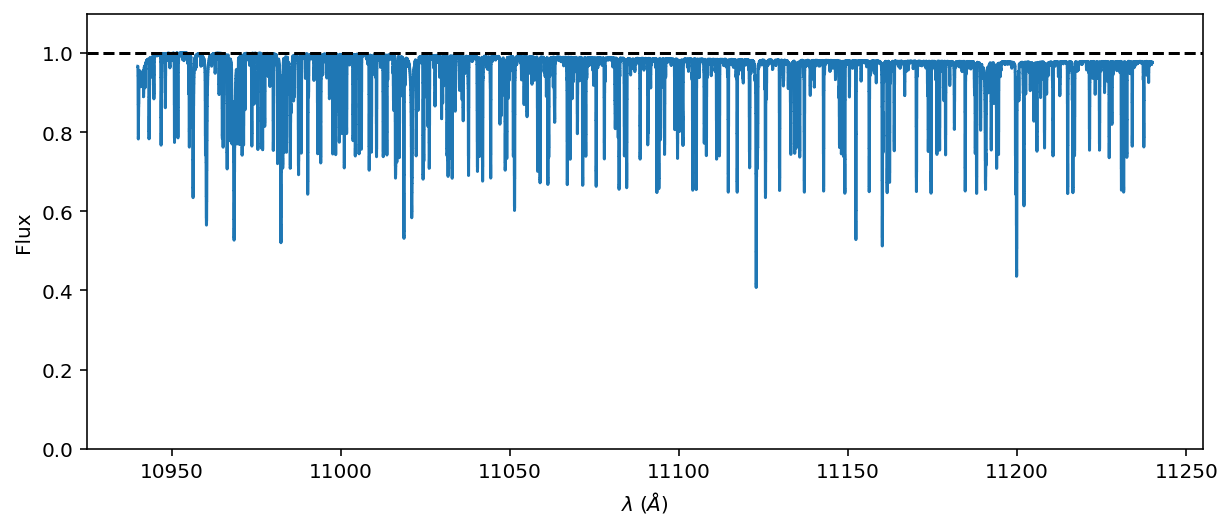

In [8]:
ax = stellar_spectrum.plot()
ax.axhline(1.0, color='k', linestyle='dashed')
ax.set_ylim(0.0,1.1)

Lame, its not a great continuum flattening.  Mine was better!!

## Clone the stellar model

We make an emulator for the spectrum by cloning all of the spectral lines above some prominence threshold:

In [9]:
import matplotlib.pyplot as plt

In [10]:
import math
import jax
import jax.numpy as jnp
import numpy as np
from scipy.signal import find_peaks, peak_prominences, peak_widths
#jax.config.update("jax_enable_x64", True)

In [11]:
flux_native = stellar_spectrum.flux.value
wl_native = stellar_spectrum.wavelength.value

In [12]:
prominence = 0.01

In [13]:
from blase.jaxemulator import LinearEmulator, SparseLinearEmulator

In [14]:
linear_emulator = LinearEmulator(wl_native, flux_native, prominence=prominence)

In [15]:
sparse_emulator = SparseLinearEmulator(wl_native, flux_native, prominence=prominence, wing_cut_pixels=1000)

Initializing a sparse model with 424 spectral lines


In [16]:
vec = sparse_emulator.sigma_widths

In [17]:
jnp.expand_dims(vec, 0).shape

(1, 424)

In [18]:
sparse_emulator.forward(sparse_emulator.amplitudes)

DeviceArray([0.9912127 , 0.9911165 , 0.99085563, ..., 0.9953159 ,
             0.99398255, 0.9913873 ], dtype=float32)

In [19]:
target = flux_native[sparse_emulator.active_mask]
wl_active = wl_native[sparse_emulator.active_mask]

(0.0, 1.1)

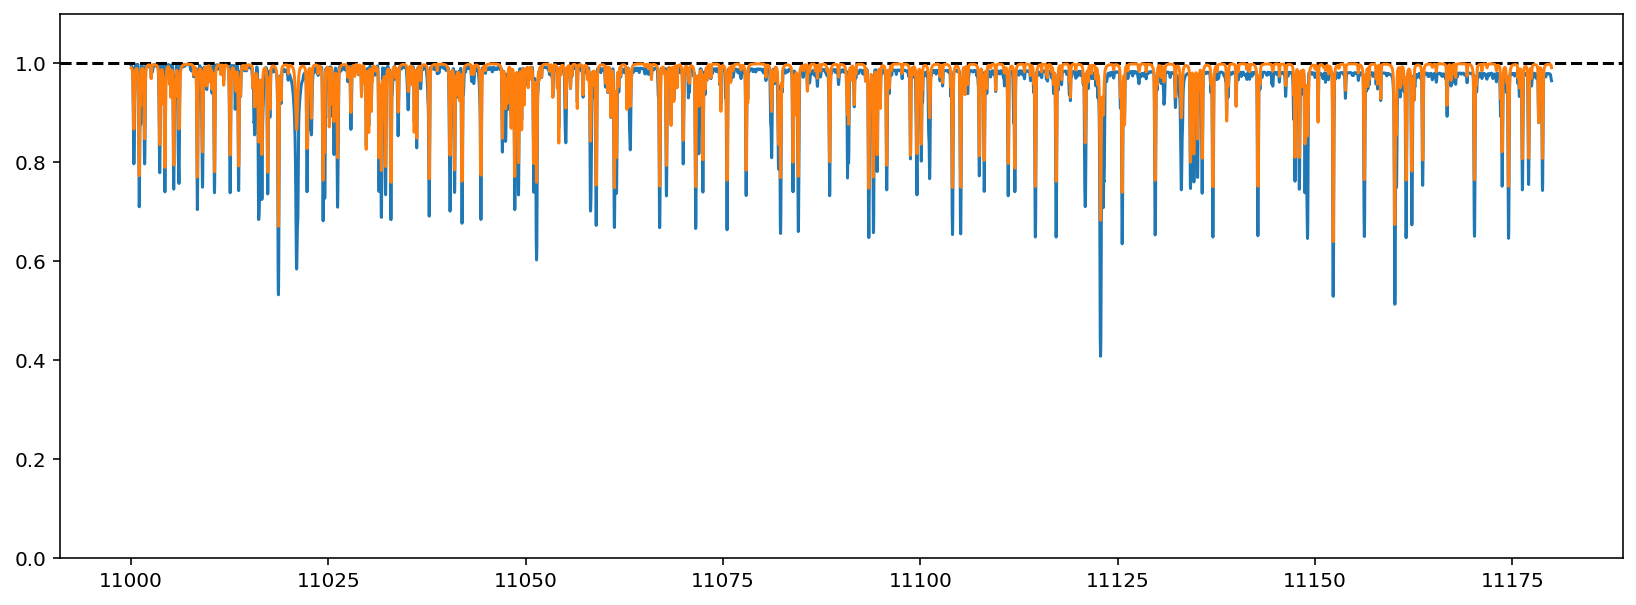

In [20]:
plt.figure(figsize=(14, 5))
plt.plot(wl_active, target)
plt.axhline(1.0, color='k', linestyle='dashed')
plt.plot(wl_native[sparse_emulator.active_mask], sparse_emulator.forward(sparse_emulator.amplitudes))
plt.ylim(0.0,1.1)

## Optimize

In [21]:
import optax

In [22]:
initial_params = {
    'ln_amplitudes': sparse_emulator.amplitudes,
}


def loss(params: optax.Params):
    y_hat = sparse_emulator.forward(params['ln_amplitudes'])
    loss_value = optax.l2_loss(y_hat, target).sum()
    return loss_value

In [23]:
loss(initial_params)

DeviceArray(5.7003813, dtype=float32)

In [24]:
def fit(params: optax.Params, optimizer: optax.GradientTransformation) -> optax.Params:
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state):
        loss_value, grads = jax.value_and_grad(loss)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for i in range(1_000):
        params, opt_state, loss_value = step(params, opt_state)
        if i % 100 == 0:
            print(f'step {i}, loss: {loss_value}')

    return params

# Finally, we can fit our parametrized function using the Adam optimizer
# provided by optax.
optimizer = optax.adam(learning_rate=1e-3)
params = fit(initial_params, optimizer)
params

step 0, loss: 5.700381278991699
step 100, loss: 4.4533233642578125
step 200, loss: 3.438363552093506
step 300, loss: 2.6777617931365967
step 400, loss: 2.1458487510681152
step 500, loss: 1.7865742444992065
step 600, loss: 1.5434467792510986
step 700, loss: 1.3761504888534546
step 800, loss: 1.260003924369812
step 900, loss: 1.1799192428588867


{'ln_amplitudes': DeviceArray([-3.482273 , -3.336483 , -5.3204627, -3.5247273, -3.9207869,
              -5.478846 , -6.3338194, -3.41516  , -4.0115066, -3.3757317,
              -5.273929 , -5.935149 , -3.486652 , -3.3767858, -5.19825  ,
              -3.6597805, -5.138203 , -4.838769 , -4.4560175, -3.373849 ,
              -5.575392 , -6.040296 , -3.2949634, -2.7037966, -3.4151282,
              -3.4060438, -5.833192 , -3.3904426, -5.45212  , -3.2305343,
              -5.6699944, -4.736398 , -4.135657 , -4.3219066, -3.157955 ,
              -3.3614042, -6.39778  , -4.7498684, -3.9183872, -5.3438787,
              -6.603884 , -4.8842916, -3.502926 , -4.02639  , -3.477191 ,
              -5.473908 , -5.2230806, -6.6639323, -6.497345 , -6.2965837,
              -5.187345 , -6.458065 , -5.375084 , -4.434958 , -3.6168432,
              -5.238771 , -3.6116345, -4.327947 , -3.8860126, -6.360156 ,
              -3.1099565, -2.9150636, -4.7487464, -3.2608907, -5.5494976,
              -3.1688

(11075.0, 11100.0)

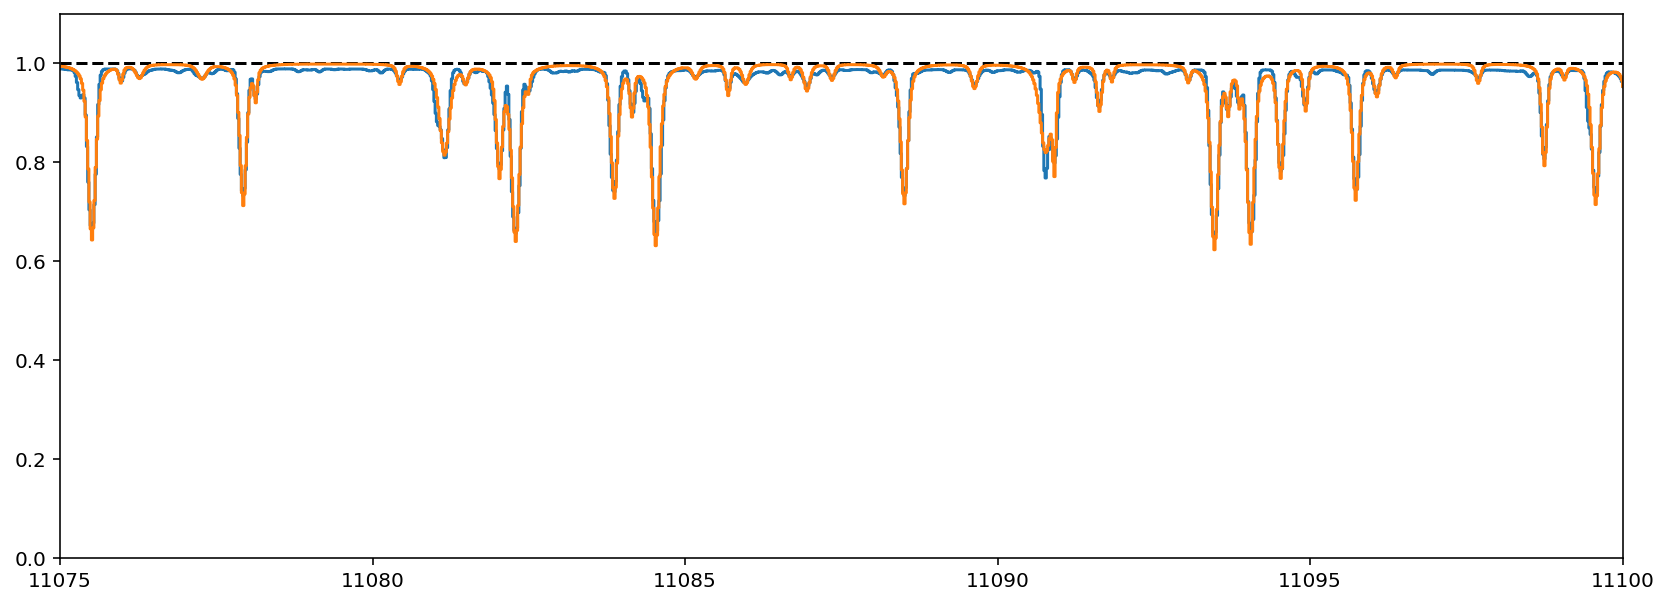

In [25]:
plt.figure(figsize=(14, 5))
plt.step(wl_active, target)
plt.axhline(1.0, color='k', linestyle='dashed')
plt.step(wl_native[sparse_emulator.active_mask], sparse_emulator.forward(params['ln_amplitudes']))
plt.ylim(0.0,1.1)
plt.xlim(11_075, 11_100)

(0.0, 1.1)

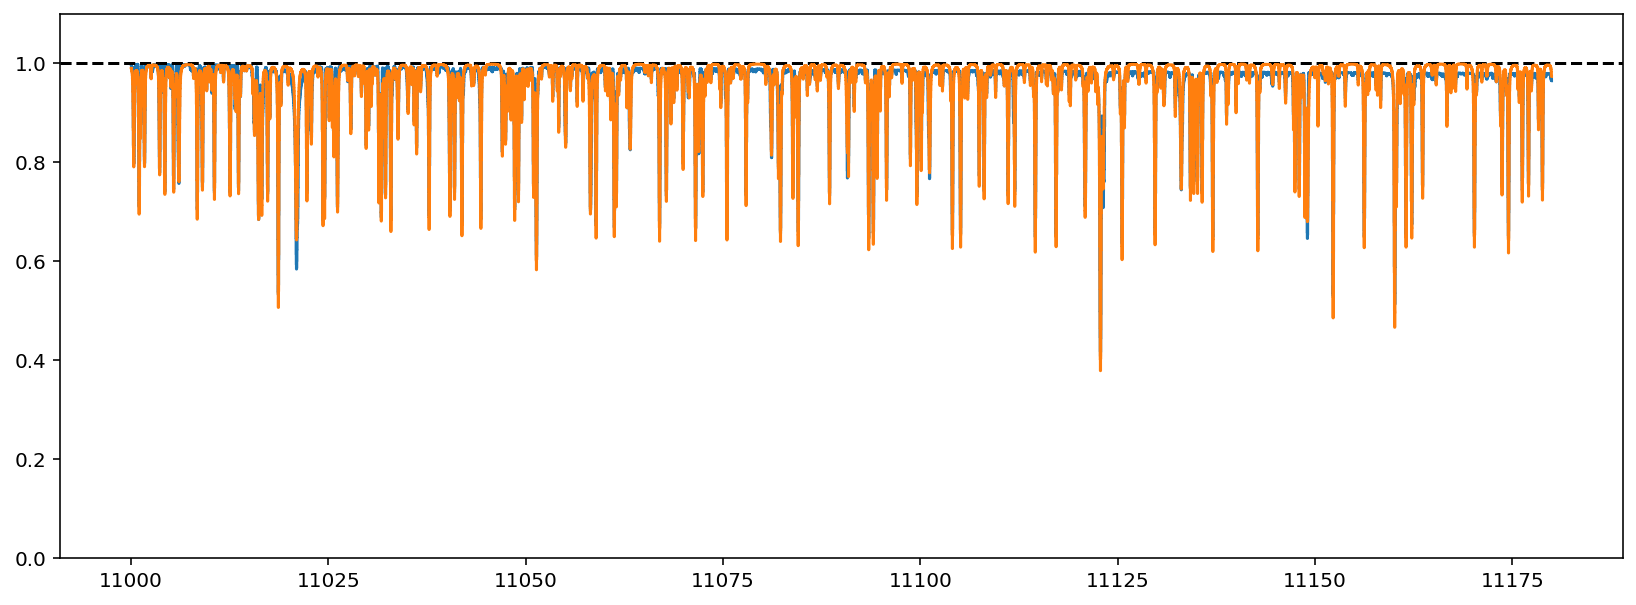

In [26]:
plt.figure(figsize=(14, 5))
plt.step(wl_active, target)
plt.axhline(1.0, color='k', linestyle='dashed')
plt.step(wl_native[sparse_emulator.active_mask], sparse_emulator.forward(params['ln_amplitudes']))
plt.ylim(0.0,1.1)
